In [1]:
!pip install mtcnn tensorflow keras numpy opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from mtcnn import MTCNN
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=0457a3cbf8ee3b9aef94a221a921527d3b8c48680701429aa46616803c30fd5e
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [4]:
from keras_facenet import FaceNet
embedder = FaceNet()

In [5]:
detector = MTCNN()  # Face detection
embedder = FaceNet()  # FaceNet model for embeddings

In [6]:
def extract_faces(image_path):
    """Detects faces and returns face images with bounding boxes."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = detector.detect_faces(img_rgb)

    faces = []
    bounding_boxes = []

    for face in detections:
        x, y, width, height = face['box']
        face_img = img_rgb[y:y+height, x:x+width]
        faces.append(face_img)
        bounding_boxes.append((x, y, width, height))

    return faces, bounding_boxes, img_rgb

In [7]:
def get_face_embeddings(faces):
    """Extracts embeddings for each face."""
    embeddings = [embedder.embeddings([face])[0] for face in faces]
    return embeddings

In [8]:
from google.colab import files

print("Upload the group image:")
uploaded = files.upload()
group_image_path = list(uploaded.keys())[0]

group_faces, group_boxes, group_img = extract_faces(group_image_path)
group_embeddings = get_face_embeddings(group_faces)

Upload the group image:


Saving Img1.jpeg to Img1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [9]:
print("Upload individual face images:")
uploaded_individuals = files.upload()

individual_embeddings = {}
for filename in uploaded_individuals.keys():
    ind_faces, _, _ = extract_faces(filename)
    if ind_faces:
        individual_embeddings[filename] = get_face_embeddings(ind_faces)[0]  # Single face per image

Upload individual face images:


Saving sreya2.jpeg to sreya2.jpeg
Saving chetan3.jpg to chetan3.jpg
Saving bhoomi.jpeg to bhoomi.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [16]:
def match_faces(group_embeddings, individual_embeddings, threshold=0.5):
    """Compares individual faces with group faces and returns matches."""
    results = {}

    for name, ind_embedding in individual_embeddings.items():
        max_sim = 0
        matched_index = -1

        for i, group_embedding in enumerate(group_embeddings):
            similarity = cosine_similarity([ind_embedding], [group_embedding])[0, 0]
            if similarity > max_sim and similarity > threshold:
                max_sim = similarity
                matched_index = i

        results[name] = matched_index if matched_index != -1 else "Not Found"

    return results

In [17]:
# Perform Matching
face_matching_results = match_faces(group_embeddings, individual_embeddings)

for person, matched_idx in face_matching_results.items():
    if matched_idx != "Not Found":
        print(f"{person} matched with Face {matched_idx + 1} in the group image.")
    else:
        print(f"{person} not found in the group image.")

sreya2.jpeg not found in the group image.
chetan3.jpg matched with Face 2 in the group image.
bhoomi.jpeg matched with Face 1 in the group image.


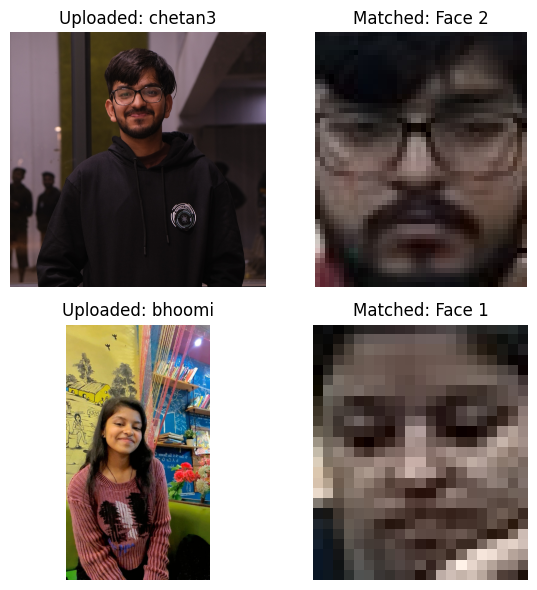

In [14]:
import matplotlib.pyplot as plt
import os
import cv2

# Set the correct path to the faces directory
faces_dir = "/content/faces/"

# Count the number of matched faces
num_matches = sum(1 for v in face_matching_results.values() if v != "Not Found")

# If no matches are found, print a message and exit
if num_matches == 0:
    print("No matches found. Nothing to display.")
else:
    # Set up the figure dynamically based on the number of matches
    fig, axes = plt.subplots(num_matches, 2, figsize=(6, num_matches * 3))

    # Ensure axes is always a 2D array even when num_matches == 1
    if num_matches == 1:
        axes = [axes]  # Convert to a list of lists for consistency

    # Keep track of row index for plotting
    row_idx = 0

    for person, matched_idx in face_matching_results.items():
        if matched_idx != "Not Found":  # Only plot matched faces
            # Construct the correct file path
            uploaded_face_path = os.path.join(faces_dir, person)
            uploaded_face = cv2.imread(uploaded_face_path)

            # Check if the image is successfully loaded
            if uploaded_face is None:
                print(f"Error: Unable to load {uploaded_face_path}")
                continue  # Skip this face if file is missing

            uploaded_face = cv2.cvtColor(uploaded_face, cv2.COLOR_BGR2RGB)

            # Extract the matched face from the group image
            x, y, w, h = group_boxes[matched_idx]
            matched_face = group_img[y:y+h, x:x+w]  # Crop the matched face

            # Plot the uploaded face
            axes[row_idx][0].imshow(uploaded_face)
            axes[row_idx][0].axis("off")
            axes[row_idx][0].set_title(f"Uploaded: {person.split('.')[0]}")

            # Plot the matched face from the group image
            axes[row_idx][1].imshow(matched_face)
            axes[row_idx][1].axis("off")
            axes[row_idx][1].set_title(f"Matched: Face {matched_idx + 1}")

            row_idx += 1  # Move to next row

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
